# HW5: Tracking and Optical Flow

In this HW assignment you will implement the following experiments:
* Find "Good Features to Track" with the Shi-Tomasi eigenvalue criterion
* Lucas-Kanade optical flow with image gradients and the autocorrelation matrix
* Build a simple tracking particle filter with skin detection backpropagation
* Build a MOSSE correlation filter tracker according to the research paper

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io

## Good Features To Track and Lucas-Kanade Optical Flow

1. Find "good features to track" using the Shi & Tomasi criterion: $\min(\lambda_1,\lambda_2)<\lambda_t$, where the lambdas are the eigenvalues of the autocorrelation matrix $A$.
2. Find features using the harmonic mean criterion: $\displaystyle\frac{\det A}{\mathrm{tr} A}$ (instead of an eigen decomposition of $A$)

Recall the autocorrelation matrix is 
$$
A=\nabla I \nabla I^\top=\begin{pmatrix} \sum I_x^2 & \sum I_x I_y \\ \sum I_x I_y & \sum I_y^2 \end{pmatrix}
$$
where $I_x,I_y$ are image derivatives (e.g. `cv2.Sobel`). The summation can be taken with a simple Gaussian window (convolution, `cv2.GaussianBlur`).

Then, for the features that pass the threshold test, calculate the Lucas-Kanade/Horn-Schnuck optical flow that arises from the following: $I_xu + I_yv + I_t = 0$, where $I_t$ is the derivative in **time**.
$$
A^\top Ax = A^\top b \Rightarrow \begin{bmatrix} \sum I_x^2 & \sum I_x I_y \\ \sum I_x I_y & \sum I_y^2 \end{bmatrix}
\begin{pmatrix}u\\v\end{pmatrix}=
\begin{bmatrix}-\sum I_x I_t \\ -\sum I_y I_t\end{bmatrix}
$$

In [ ]:
# load two images
#img1_url = 'https://drive.google.com/uc?export=download&id=1G2Ttfs-g3P3ymWctChghavvEowtIjjFZ'
#img2_url = 'https://drive.google.com/uc?export=download&id=1EipIxb6yVj_6W4Ol-7F9VcNwyc7IXZoS'
img1_url = '0022.jpg'
img2_url = '0024.jpg'


img1 = io.imread(img1_url)
img2 = io.imread(img2_url)
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

In [ ]:
# calculate image derivatives: ix, iy, ixy, as well as their squares ixx = ix^2, iyy = iy^2
# e.g. `ix  = cv2.Sobel(im1g, cv2.CV_32F, 1, 0)` (iy similarly but with 0,1)
ix  = cv2.Sobel(img1_gray, cv2.CV_32F, 1, 0)
iy  = cv2.Sobel(img1_gray, cv2.CV_32F, 0, 1)
# to implement the summation in the autocorrelation matrix above we convolve the dx,dy images with 
# a gaussian kernel.
# use cv2.GaussianBlur to do this to obtain ixx (ix ** 2), iyy (iy ** 2), ixy (ix * iy)
sigma = 0
ksize = (5,5)
ixx = cv2.GaussianBlur(ix**2,ksize,sigma)
iyy = cv2.GaussianBlur(iy**2,ksize,sigma)
ixy = cv2.GaussianBlur(ix*iy,ksize, sigma)
# get the gaussian blurred images of ix and iy - for visualization purposes
gix = cv2.GaussianBlur(ix,ksize, sigma)
giy = cv2.GaussianBlur(iy,ksize, sigma)

Show image derivatives

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(151),plt.imshow(ixx),plt.title("G(Ix**2)");
plt.subplot(152),plt.imshow(iyy),plt.title("G(Iy**2)");
plt.subplot(153),plt.imshow(ixy),plt.title("G(Ix*Iy)");
plt.subplot(154),plt.imshow(gix),plt.title("G(Ix)");
plt.subplot(155),plt.imshow(giy),plt.title("G(Iy)");

Calculate $A$'s eigenvalues and det/tr in each pixel:

In [ ]:
ixxr,iyyr,ixyr = ixx.ravel(),iyy.ravel(),ixy.ravel() # flatten to 1D for ease of iteration
im_eig = np.zeros_like(ixxr)
im_det_tr = np.zeros_like(ixxr)

for i in range(ix.size):
    # construct the autocorrelation matrix A
    # the matrix A is a 2x2 matrix made from the flattened ixx, ixy, iyy images (i.e. ixxr, ixyr, iyyr)
    A = np.array([[ixxr[i], ixyr[i]],[ixyr[i],iyyr[i]]])
    # take eigen decomposition of A using `np.linalg.eig()`
    d,_ = np.linalg.eig(A)
    # find the minimal EV from d with `np.min()`
    im_eig[i] = np.min(d)
    
    # calculate the det/tr method (e.g. using `np.linalg.det()`, `A.trace()`)
    # take care to check for division by zero (i.e. A.trace() != 0)
    if A.trace() != 0:
        im_det_tr[i] = np.linalg.det(A)/A.trace()
    
im_eig = np.abs(im_eig).reshape(img1_gray.shape) # reshape back to 2D
im_det_tr = np.abs(im_det_tr).reshape(img1_gray.shape) # reshape back to 2D

To get corners we apply non-maximal suppression:

In [ ]:
# a small utility to do Non-Maximal Suppression to get the actual corner points
# returns a list[(y0,x0), (y1,x1), (y2,x2), ...]
def cornersNonMaxSuppressionAndThreshold(im, thresh, nms_kernel=(3,3)):
    ima_d = cv2.dilate(im,np.ones(nms_kernel,np.uint8))
    corners_im = np.all([(im > thresh).ravel(), (im == ima_d).ravel()], axis=0).reshape(im.shape).astype(np.uint8)
    corners_ctrs,_ = cv2.findContours(corners_im, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    corners = [np.mean(ctr, axis=0) for ctr in corners_ctrs]
    corners = np.flip(np.squeeze(np.array(corners)).astype(np.int32), 0)
    return corners, corners_im

In [ ]:
# get the corner points
corners_eig, corners_im_eig = cornersNonMaxSuppressionAndThreshold(im_eig, 3000, (5,5))
corners_det_tr, corners_im_det_tr = cornersNonMaxSuppressionAndThreshold(im_det_tr, 3000, (5,5))

Show the detected corners

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(231),plt.imshow(im_eig),plt.colorbar(),plt.title('min eig.val image')
plt.subplot(232),plt.imshow(corners_im_eig),plt.title('detected corners image')
plt.subplot(233),plt.imshow(img1),plt.scatter(corners_eig[:,0],corners_eig[:,1], c='r'),plt.title('corners');
plt.subplot(234),plt.imshow(im_det_tr),plt.colorbar(),plt.title('det/tr image')
plt.subplot(235),plt.imshow(corners_im_det_tr),plt.title('detected corners image')
plt.subplot(236),plt.imshow(img1),plt.scatter(corners_det_tr[:,0],corners_det_tr[:,1], c='r'),plt.title('corners');

### Tracking the corners with L-K optical flow

In [ ]:
# calculate the It (derivative of the image in time), which is the difference (`-`) between the two images
it = img1_gray - img2_gray
# calculate the ItIx and ItIy images (e.g. ix * it, iy * it). Use cv2.GaussianBlur again to simulate the summation
ixit = cv2.GaussianBlur(ix*it,ksize,0)
iyit = cv2.GaussianBlur(iy*it,ksize,0)

The L-K OF poses an $Ax=b$ linear system from $\nabla I$ and $\nabla t$ (shown above). Solve it for every pixel to obtain the local motion.

In [ ]:
uv = []
# iterate over the corners locations
for p in corners_eig:

    p = (p[1],p[0])
    #print(p)
    # construct the autocorrelation matrix A again
    # e.g. `A = np.array([[ixx[p], ...`
    A = np.array([[ixx[p], ixy[p]],[ixy[p],iyy[p]]])
    # construct the b vector, e.g. `np.array([[-ixit[p]]...`
    b = np.array([[-ixit[p]],[-iyit[p]]])
    # solve for the uv (dx,dy) vector using `np.linalg.solve()`
    p_uv =  np.linalg.solve(A,b)
    # append p_uv to list. make sure to use `np.squeeze()` to remove the extra dimension
    uv.append(np.squeeze(p_uv))

uv = np.array(uv) # convert to numpy array
# select the points that have a motion of > 0.1, e.g. `np.linalg.norm(uv, axis=1) > 0.1`
uv_selection = np.linalg.norm(uv, axis = 1) > .2

# normalize the uv's by dividing by `np.linalg.norm()` (use axis=1 and keepdims=True)
uv = uv/np.linalg.norm(uv_selection,axis=0,keepdims=True)



Show the movement vectors:

In [ ]:
plt.imshow(img1)
plt.quiver(corners_eig[uv_selection,0],corners_eig[uv_selection,1],uv[uv_selection,1],uv[uv_selection,0])
#plt.imshow(img1)
#cv2.calcOpticalFlowPyrLK(img1,img2,)

You've implemented an Optical Flow algorithm from scratch - how cool is that?

You may want to compare your results to OpenCV's `cv2.cornersMinEigenVal`, `cv2.goodFeaturesToTrack` and `cv2.calcOpticalFlowPyrLK`

---

In [ ]:
# for the next bit on tracking we will need to download a video.
# download the video from here: https://drive.google.com/uc?export=download&id=16e4U2oPNbPT6iNS4JlRLR3OBkhyimGnE
# use python urllib to download the video (or download it manually and use a file path)
import urllib.request
url = 'https://drive.google.com/uc?export=download&id=16e4U2oPNbPT6iNS4JlRLR3OBkhyimGnE'
urllib.request.urlretrieve(url, '60139361.mp4');

## Simple Tracking Particle Filter

Using a particle filter for tracking objects is a very common use case. It's a simple algorithm that is easy to implement, but it's still quite powerful. The abundance of particles (hypotheses) gives us statistical advantage through numbers, and instead of an explicit modeling of a distribution we get an implicit one that arises from the particle cloud.

The main idea in the particle filter is to keep many parallel "hypoteses" of where the object is, which we validate in each frame.
Each particle is given a weight that's derived from the image. In our case we use a simple color histogram model in the HSV image, but other things we could use are edge orientations (HOG) or maybe textures.

We apply a motion model (in our case here, just a "random motion") to the particles every frame. This can be somewhat similar to the Kalman filter where we track velocity etc.

We resample the implicit distribution every frame, and "replicate" the strong particles while discarding the weak.

In [ ]:
class ParticleFilter(object):
  def __init__(self, im_shape_hw, stepsize, num_particles):
    self.stepsize = stepsize
    self.n = num_particles
    # Initial weights, uniform
    self.w = np.ones(self.n)/self.n
    #print("weights init:")
    #print(self.w)
    self.imw, self.imh = im_shape_hw


  def pretraining(self, im, roi):
    # Initial particle positions - all are around the roi center
    x, y, w, h = roi
    # the center of the roi, e.g. `[x + w/2, y + h/2]`
    pos = np.array([x + w/2, y + h/2], int)
    # use np.random.uniform to generate random numbers in the range of `[-2*stepsize, 2*stepsize]`
    # use `np.int64` to convert to int64 (these are the positions of the particles)
    # add the `pos`` to the random numbers to get the particle positions around it
    self.x = pos + np.int64(np.random.uniform(-2*self.stepsize, 2*self.stepsize, (self.n,2)))
    # take just the roi from the image im, e.g. `[y:y+h, x:x+w]`
    im_patch = im[y:y+h, x:x+w]
    # convert to HSV color space with cv2.cvtColor and cv2.COLOR_BGR2HSV
    im_patch = cv2.cvtColor(im_patch,cv2.COLOR_BGR2HSV)
    # create an eliptical mask of the same size as the roi
    mask = np.zeros((h,w), np.uint8)
    # use cv2.ellipse to create the mask. set the center to be the center of the roi (w//2, h//2)
    # the axes should be (w//2-20, h//2-20), the angle should be 0, the start and end angles should 
    # be 0 and 360
    cv2.ellipse(mask, (w//2, h//2), (w//2-20, h//2-20), 0, 0, 360, (255,255,255), thickness=-1)
    # keep only the HS channels, e.g. [:,:,:2]
    im_patch = im_patch[:,:,:2]

    # compute the histogram of the image patch in the roi using the mask and cv2.calcHist
    # the histogram should have 24 bins in each dimension, and the ranges should be [0, 180, 0, 256]
    # the channels should be [0, 1], and don't forget to apply the mask
    # save the histogram in `self.hist`
    histSize = [24, 24]
    ranges = [0, 180, 0, 256]
    channels = [0, 1]
    self.hist = cv2.calcHist([im_patch], channels, mask, histSize, ranges)    
    # Normalize the histogram to [0, 1] with cv2.normalize and cv2.NORM_MINMAX
    cv2.normalize(self.hist, self.hist, 0, 1, cv2.NORM_MINMAX)


  def find_particles_weights(self, im):
    # convert the image to HSV space same as in pretraining
    im_hsv = cv2.cvtColor(im,cv2.COLOR_BGR2HSV)
    # keep only the HS channels
    im_hs = im_hsv[:,:,:2]
    
    # compare the image color at all particle potisions to target color histogram
    # using cv2.calcBackProject, the channels should be [0, 1], the ranges should be [0, 180, 0, 256]
    # and the scale should be 1
    channels = [0,1]
    ranges = [0, 180, 0, 256]
    scale = 1
    #print(self.hist)
    back_projection = cv2.calcBackProject([im_hs], channels, self.hist, ranges, scale)
    self.w = back_projection[self.x[:,1],self.x[:,0]]

    #if np.sum(self.w) != 0:
    self.w = self.w/np.sum(self.w) 


  def update_frame(self, im):
    # Particle motion model: step (self.stepsize) in a random direction
    # use np.random.uniform to generate random numbers in the range of `[-stepsize, stepsize]`
    # use `np.int64` to convert to int64 (these are the positions of the particles)
    # add the random numbers to the current particle positions (self.x)
 
    self.x += np.int64(np.random.uniform(-self.stepsize, self.stepsize, self.x.shape))
      
    ## Clip out-of-bounds particles
    ##self.x = np.clip(self.x, 0, [self.imw-1, self.imh-1]) #THIS LINE WAS MY PROBLEM
    self.find_particles_weights(im)

    # Reweight if too few effective particles
    threshold = np.uint8(1e-3)
    #print(self.w)
    if np.sum(self.w) < threshold:
      self.w += threshold
      if np.sum(self.w) != 0:
        self.w = self.w/np.sum(self.w) 
      

    # Resample particles, select (replicate) the better particles
    particles_to_keep = self.resample(self.w)
    self.x = self.x[particles_to_keep]
    self.w = self.w[particles_to_keep]

    # Return expected position, which is the weighted average of the particles
    # use np.average to get the weighted average of the particles (self.x) and weights (self.w)
    # return the particles and weights for visualization as well

    expected_position = np.average(self.x, weights=self.w, axis=0)
    return expected_position, self.x, self.w
  

  def resample(self, weights):
    #print('Resample')
    '''
    Resample particles according to their weights.
    We want to replicate particles with high weights and discard particles with low weights.
    For example, if we have 3 particles with weights [0.1, 0.2, 0.11, 0.7], we want to keep the last 
    particle more than the others.
    We can do this by scanning the cumulative distribution function (CDF) from the weights.
    For example, the CDF for the weights above is [0.0, 0.1, 0.3, 0.41, 1.0]. 
    We can then pick a random number u0 between 0 and 1, for example 0.5.
    We construct a list: [0.5/4, (0.5+1)/4, (0.5+2)/4, (0.5+3)/4] = [0.125, 0.375, 0.625, 0.875]
    We then scan the CDF, and for each u in the list, we find the first index j
    such that CDF[j] > u. The index j-1 is a particle we want to keep.
    Using the example above:
     - u = 0.125. 
     - j = 0, CDF[j] = 0.0 < u, so we skip it. 
     - j = 1, CDF[j] = 0.1 < u, so we skip it.
     - j = 2, CDF[j] = 0.3 > u, so we keep the particle with index j-1 = 1.
     - now, u = 0.375.
     - j = 2, CDF[j] = 0.3 < u, so we skip it.
     - j = 3, CDF[j] = 0.41 > u, so we keep the particle with index j-1 = 2.
     - now, u = 0.625.
     - j = 3, CDF[j] = 0.41 < u, so we skip it.
     - j = 4, CDF[j] = 1.0 > u, so we keep the particle with index j-1 = 3.
     - now, u = 0.875.
     - j = 4, CDF[j] = 1.0 > u, so we keep the particle with index j-1 = 3.
    So the final list of indices is [1, 2, 3, 3], which means we want to keep the second, third, 
    and fourth particles.
    '''
    indices = []
    # Build CDF (cumulative distribution function) from weights
    # The CDF is a list of cumulative sums of the weights, e.g. [0.1, 0.3, 0.41, 1.0]
    # you can use the `sum` function to get the cumulative sum of weights by iterating over it
    # e.g. `weights[:i+1]` will sum the first i weights. do that for i in range(n)
    CDF = [0.] + [sum(weights[:i+1]) for i in range(len(weights))]
    
    # pick a random number u0 between 0 and 1
    u0 = np.random.random()
    j = 0  # selection index over the particles
    # for each u in the list [u0/n, (u0+1)/n, (u0+2)/n, ...]
    for u in [(u0+i)/len(weights) for i in range(len(weights))]:
      # If this particle has a higher weight than u, add it to the list of indices, otherwise move on
      
      while u > CDF[j]:
        # increment the j index until we find a particle with a higher weight than u
        j += 1
      # Add the index to the list of indices
      indices.append(j-1)

    return indices

In [ ]:
# let's run the tracker on the video
cap = cv2.VideoCapture("60139361.mp4")

# roll the video back to the beginning
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# setup initial location of window
r, h, c, w = 576, 474, 178, 146  # simply hardcoded the values

ret,frame = cap.read()
roi = (c, r, w, h)



# initialize the particle filter tracker with W,H shape of the frame, step size 50 and 100 particles
tracker = ParticleFilter((w,h),50,100)
# run the pretraining step to get the initial particles and weights with the first frame and roi
# you can use the tracker.pretraining method to do this
tracker.pretraining(frame,roi)
#tracker.find_particles_weights(frame)
tracker.update_frame(frame)


#
# setup video writer to capture a video of the tracking process for your viewing pleasure
# the video file does not need to be submitted
out = cv2.VideoWriter(
    f'60139361_particle.mp4',
    cv2.VideoWriter_fourcc(*'MP4V'), 30.0, (frame.shape[1],frame.shape[0]))



key_frames = []
 #Tracking Loop
while(cap.isOpened()):
    ret,frame = cap.read()
    if not ret:
        break

    # update the tracker with the new frame with the tracker.update_frame() method
    # get the new center of the roi
    new_center, particles, weights = tracker.update_frame(frame)

    # unpack the roi center from the new frame
    x, y = (new_center - np.array([w,h])/2).astype(int)
    # draw the new roi on the frame with cv2.rectangle and x,y,w,h
    frame = cv2.rectangle(frame,(x,y),(x+w,y+h), (0,0,0), 7)
    # draw the particles on the frame
    for p in particles:
        # draw the particles on the frame with cv2.circle and p,1,(0,0,255),2
        frame = cv2.circle(frame,p,1,(0,155,255),2)

    # save every 20th frame to show the tracking process
    if cap.get(cv2.CAP_PROP_POS_FRAMES) % 20 == 0:
        key_frames.append(frame)

    # write the frame to the video
    out.write(frame)
        
cap.release()
out.release()

In [ ]:
# show the tracking process
cols = len(key_frames)//3
fig, ax = plt.subplots(3, cols, figsize=(20, 10))
for i, frame in enumerate(key_frames):
    #frame = cv2.rectangle(frame,(x,y),(x+w,y+h), (0,255,0), 1)
    ax[i//cols][i%cols].imshow(frame[:,:,::-1])
    #ax[i//cols][i%cols].axis('off')
    ax[i//cols][i%cols].set_title(f'Frame {i*20}')
plt.tight_layout()
plt.show()

Looks like the simple particle filter tracker is quite successful! 

---

## MOSSE Correlation Filter Tracker

The Minimum Output Sum of Squares Error (MOSSE) tracker ushered in an era in tracking of using correlation filters for images. It is a seminal piece of work that was later extended to many very powerful trackers, both in speed (computation) and performance.

Let's try our hand at building a MOSSE tracker. It may be simpler than you expect...

The paper can be accessed for example here: [Visual Object Tracking using Adaptive Correlation Filters](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=70c3c9b9a40ca55264e454586dca2a6cf416f6e0). It was authored by Bolme et al in 2010 and published in CVPR; to date it received more than 3500 citations. Follow up work from this paper went on to make great contributions like the [KCF](https://ieeexplore.ieee.org/iel7/34/4359286/06870486.pdf?casa_token=91yFVenSkRwAAAAA:j3qx502p9PcY_YxLNusEBs7Ngk5_DqezXsy0AEECtyJeqneJdZMUm-dp6bdY6aRovCRvSLk) (>5500 citations), [CSRT](https://openaccess.thecvf.com/content_cvpr_2017/papers/Lukezic_Discriminative_Correlation_Filter_CVPR_2017_paper.pdf), and many many others.

The big idea in MOSSE is finding an optimal correlation filter. 

Assuming we have a "filter" $h$ (just a patch of pixels we assume capture the object's appearance) we can convolve it with the image to get the correlation map: for every position in the image, how much does it correlate with the filter patch. 
In the Fourier domain ($\mathcal{F}$ operator), according to the convolution theorem, this would be a simple element wise multiplication:
$$
H = \mathcal{F}(h)\\
F = \mathcal{F}(f)\\
G = F \odot H
$$
This allows us to "design" a filter if we can produce the "perfect correlation map" $g'$ (which has a bright spot where the object is and 0 everywhere else) and take it's Fourier transform $G'$:
$$
G' = \mathcal{g'}\\
H^* = \frac{G'}{F}
$$
(The $H^*$ is the complex conjugate. Basically just flipping the sign of the imaginary part, performed in code by `np.conj`)

This is the big idea behind MOSSE. The additional parts of MOSSE have to do with finding a "correlation filter" (patch) that will be "sticky" and correlate very strongly with the object without losing it immediately.

The MOSSE paper suggests the for the initialization we take several patches that staisfy the followng error functional (Minimum Output SSE = MOSSE):
$$
\min_{H} \sum_i |F_i \odot H_i - G_i'|^2
$$
After some derivations the filter can be found:
$$
H^* = \frac{\sum G_i \odot F_i}{\sum F_i \odot F_i^*} = \frac{A_i}{B_i}
$$
We denote $F_i,G_i$ because we manipulate the image ($F$) and the "desired" gaussian correlation map ($G$) for $N$ times (8 in the paper).
For brevity we use $A_i$ and $B_i$.

This is pretty much it. It's a simple and powerful idea. Now let's get to implementing it!

In [316]:
class MOSSE:
    '''
    TUNING PARAMS:
    learning_rate
    train_num
    sigma
    rotation angle in affine transformation
    '''

    def __init__(self, frame, roi, learning_rate, train_num, sigma):
        self.frame = frame
        self.roi = roi                      # contains (top_left_x, top_left_y, width, height)
        self.learning_rate = learning_rate  # running average parameter 
        self.train_num = train_num          # number of training examples to be trained on
        self.sigma = sigma                  # parameter for calculating gaussian map 


    def get_gaussian_map(self) -> np.ndarray:
        '''
        returns the desired gaussian map response
        '''

        x, y, w, h = self.roi

        # create a gaussian map with center at the center of the roi
        # start with a zero matrix (size of the frame (h,w), dtype=np.float64) using np.zeros
        
        gaussian_map = np.zeros((h,w), dtype=np.float64)
        # set the center of the gaussian map (h//2,w//2) to 1
        gaussian_map[h//2,w//2] = 1
        # apply a gaussian blur to the gaussian map using cv2.GaussianBlur
        # use w and h as the standard deviation in both x and y directions respectively
        # to make an elliptical gaussian map
        ksize = [11,11]
        gaussian_map = cv2.GaussianBlur(gaussian_map,ksize,w,sigmaY= h)
        # normalize the gaussian map to have values between 0 and 1, using the formula (x - min) / (max - min)
        # use np.min and np.max to get the min and max values of the gaussian map
        gaussian_map = (gaussian_map - np.min(gaussian_map)) / (np.max(gaussian_map)-np.min(gaussian_map))

        return gaussian_map


    def get_G(self) -> None:
        '''
        returns the fft2 (2D Discrete Fast Fourier Transform) of the gaussian response map
        '''

        x, y, w, h = self.roi #why is this here???
        # get the gaussian map using self.get_gaussian_map()
        g = self.get_gaussian_map()
        # get the fft2 of the gaussian map using np.fft.fft2 and store it in self.G
        self.G = np.fft.fft2(g)


    def preprocessing(self,f) -> np.ndarray:
        '''
        preprocessing as mentioned in MOSSE paper section 3.1
        "First, the pixel values are trans- formed using a log function which helps with low 
        contrast lighting situations. The pixel values are normalized to have a mean value of 0.0 
        and a norm of 1.0. Finally, the image is multiplied by a cosine window which gradually 
        reduces the pixel values near the edge to zero."
        '''

        h, w = f.shape


        # transformation using a log function which helps with low contrast lighting situations.
        # use np.log to get the log of the image. note that the log of 0 is undefined, so add 1 to 
        # the image
        # take care of the data type of the image f. use .astype(np.float32) to convert the image to 
        # float32 before taking the log
        
        try: 
            img = np.log((f).astype(np.float32)+1)
        except RuntimeError:
            print("RUNTIMEERROR")
            plt.imshow(img)
        #plt.imshow(img)

        # calculate the mean and standard deviation of the image with np.mean and np.std
        # normalize the image to have 0 mean and 1 SD using the formula (img - mean) / std
        img = (img - np.mean(img))/np.std(img)

        # image is multiplied by a cosine window which gradually reduces the pixel values near the edge to zero.
        # use a hanning window. Hanning window is a taper formed by using a weighted cosine
        # use np.hanning to get the hanning window of size w and h
        window_col = np.hanning(w)  
        window_row = np.hanning(h)
        # use np.meshgrid to get a 2D grid from the hanning windows
        col_mask, row_mask = np.meshgrid(window_col, window_row)
        # combine the 2 meshgrids to get the cosine image
        window = col_mask * row_mask
        # multiply the image with the cosine window to get the "reducing" effect
        img = img * window

        return img


    def get_rand_affine(self):
        '''
        returns a random affine transformation
        '''

        x, y, w, h = self.roi

        # ROI center pixel coordinates
        c_x = x + w//2
        c_y = y + h//2

        min_angle = 10
        # randomize the angle and scale with a uniform distribution (np.random.uniform)
        # the angle should be between -min_angle and min_angle
        # the scale should be between 0.95 and 1.05
        angle = np.random.uniform(-min_angle,min_angle)
        scale = np.random.uniform(0.95, 1.05)

        # rotation and scaling about the center of the ROI
        # use cv2.getRotationMatrix2D to get the rotation matrix with the center, angle and scale
        rotate_mat = cv2.getRotationMatrix2D((c_x,c_y), angle, scale)
        # add translation to the rotation matrix to create jitter
        # add random uniform to the matrix in the x and y directions at the 3rd column ([0, 2], [1, 2])
        jitter = 0.1
        #jitter = np.random.uniform(-jitter,jitter)
        rotate_mat[:1, 2] += np.random.uniform(-jitter,jitter)
        # apply affine transformation using the rotation matrix and cv2.warpAffine
        # on self.frame to get the rotated image. 
        # take care that the output image should have the same size as self.frame
        rot_img = cv2.warpAffine(self.frame, rotate_mat, self.frame.shape, None) #or use None for rot_img arg
        
        return rot_img[y:y+h, x:x+w]
        

    def pre_training(self):
        '''
        training the filter over initial frame.
        eqn 1 in the paper
        G = F . H*

        eqn 5 in the paper
        Ai = ΣGi.Fi*
        Bi = ΣFi.Fi*
        Hi* = Ai / Bi
        '''

        x, y, w, h = self.roi
        

        # initialize centered 2D gaussian map
        self.get_G()
        
        # use the self.preprocessing function to get the preprocessed image from self.frame
        # take only the roi part of the image e.g. [y:y+h, x:x+w]
        #print("roi in pre_training")
        #print((y,y+h, x,x+w))
        #print(self.frame.shape)
        f = self.preprocessing(self.frame[y:y+h, x:x+w])
        # get the fft2 of the image using np.fft.fft2
        F = np.fft.fft2(f)
        
        # initialize Ai by multiplying G and F* (np.conjugate)
        self.Ai = self.G * np.conjugate(F)
        # initialize Bi by multiplying F and F* (np.conjugate)
        self.Bi = F * np.conjugate(F)
        
        # train the filter over `self.train_num` random affine transformations
        for i in range(self.train_num):
            # get a random affine transformation using self.get_rand_affine(), preprocess it using
            # self.preprocessing and get the fft2 of it
            f = self.preprocessing(self.get_rand_affine())
            # get the fft2 of the image using np.fft.fft2
            F = np.fft.fft2(f)
            
            # update Ai and Bi by multiplying G and F* (np.conjugate) and F and F* (np.conjugate)
            # respectively and add them to the previous values of self.Ai and self.Bi
            
            self.Ai += self.G * np.conjugate(F)
            self.Bi += F * np.conjugate(F)
        
        #plt.imshow(np.real(self.Ai/self.Bi))


    def update_frame(self, frame):
        self.frame = frame
    
    
    def get_new_roi(self):
        '''
        Get new position of roi by applying filter
        eqn 1 in the paper
        G = F . H*
        '''

        x, y, w, h = self.roi
        
        # Hi = Ai / Bi (from self.Ai and self.Bi)
        self.Hi = self.Ai/self.Bi
        
        
        # use the self.preprocessing function to get the preprocessed image of the current frame
        # take only the roi part of the image e.g. [y:y+h, x:x+w]
       
        f = self.preprocessing(self.frame[y:y+h, x:x+w])
        # get the fft2 of the image using np.fft.fft2
        F = np.fft.fft2(f)
        
        # get the new filter correlation map by multiplying the fft2 of the image with the Hi filter
        self.G = F * self.Hi
        # get the inverse fft2 of the new correlation map using np.fft.ifft2
        g = np.fft.ifft2(self.G)
        
        # normalize map to 0-1 by subtracting the minimum value and dividing by the maximum value
        g = (g-np.min(g))/np.max(g) ## CHECK FOR ERROR 
        # get the maximum value with np.max and its position in the map with np.where
        max_value = np.max(g)
        max_pos = np.where(g == max_value)
        # find the average position of the maximum value in the map using np.mean and axis=1
        # since the maximum peaks in the map may be more than just at one pixel
        max_pos = np.mean(max_pos, axis=1) #WORKING CORRECTLY
        # get the movement dx,dy by subtracting the center of the map (e.g. g.shape[0] / 2) from 
        # the maximum position
        #print(max_pos)
        dy = max_pos[0] - g.shape[0]/2
        dx = max_pos[1] - g.shape[1]/2

        psr = self.psr(g)
        if psr <= 4:
            dx=0
            dy=0
            print(f'Object may be occluded or lost, PSR: {psr:.2f}')

        return (int(x + dx), int(y + dy), int(w), int(h)), psr


    def update_roi(self, roi):
        self.roi = roi

    
    def update(self):
        '''
        Update the filter using current frame features
        eqn.s 10, 11 and 12 in the paper, as a moving average
        Hi* = Ai / Bi                  (eqn 10)
        Ai = η Gi.Fi* + (1 - η) Ai-1   (eqn 11)
        Bi = η Fi.Fi* + (1 - η) Bi-1   (eqn 12)
        '''

        x, y, w, h = self.roi
        
        # initializes centered 2D gaussian correlation map
        self.get_G()

        #print("roi in update")
        #print((y,y+h, x,x+w))
        #print(self.frame.shape)
        # use the self.preprocessing function to get the preprocessed image of the current self.frame
        # take only the roi part of the image e.g. [y:y+h, x:x+w]
        f = self.preprocessing(self.frame[y:y+h, x:x+w])
        # get the fft2 of the image using np.fft.fft2
        F = np.fft.fft2(f)
        
        # filters need to quickly adapt in order to follow objects. Running average is used for this purpose.
        # update Ai and Bi by multiplying G and F* (np.conjugate) and F and F* (np.conjugate)
        # respectively and set the values of self.Ai and self.Bi to the new values
        # use the self.learning_rate for the update (see eqn.s 11 and 12 above)
        self.Ai = self.learning_rate*(self.G * np.conjugate(F)) + (1 - self.learning_rate) * self.Ai
        self.Bi = self.learning_rate*(F * np.conjugate(F)) + (1 - self.learning_rate) * self.Bi
    
    def psr(self,g):
        '''
        Calculate the peak to sidelobe ratio of the correlation map
        "The PSR is then defined as `(g_max - μ_sl) / sigma_sl` where g_max is the peak values and 
        μ_sl and sigma_sl are the mean and standard deviation of the sidelobe."
        "The sidelobe is the rest of the pixels excluding an 11x11 window around the peak."
        '''
        # get the maximum value from the correlation map g with np.max
        g_max = np.max(g)
        x, y, w, h = self.roi
        # get the center point (x,y) of the roi
        center_x = x + w//2 
        center_y = y + h//2
        # create a mask of the same size as g with all values set to True (np.ones with dtype=np.bool)
        mask = np.full(g.shape, True)
        # set the values of the mask to False in a 11x11 window around the peak
        # e.g. [center_x-5:center_x+6,center_y-5:center_y+6]
        mask[center_x-5:center_x+6,center_y-5:center_y+6] = False

        g = g.flatten()
        mask = mask.flatten()
        
        # get the sidelobe values from g using the boolean mask (just use the mask as an "index", e.g. g[mask])
        sidelobe = g[mask]
        # calculate the mean and standard deviation of the sidelobe
        # calculate the PSR using the formula above and return it
        psr = (g_max - np.mean(sidelobe))/np.std(sidelobe)
        # take care to return a real number (the real part of the complex number) using np.real
        return np.real(psr)

In [317]:
# let's run the tracker on the video
cap = cv2.VideoCapture("60139361.mp4")

# roll the video back to the beginning
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# setup initial location of window
r, h, c, w = 576, 474, 178, 146  # simply hardcoded the values

ret,frame = cap.read()
roi = (c, r, w, h)



img_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

tracker = MOSSE(img_gray, roi, learning_rate=0.1, train_num=8, sigma=100)
#map = tracker.get_gaussian_map()
#plt.imshow(map)
tracker.pre_training()
#print(tracker.get_new_roi())
#plt.imshow(tracker.preprocessing(map)), plt.subplot(1,4,2)  # get initial correlation filter
#
# setup video writer to capture a video of the tracking process
out = cv2.VideoWriter(
    f'60139361_mosse_corr.mp4',
    cv2.VideoWriter_fourcc(*'MP4V'), 30.0, (frame.shape[1],frame.shape[0]))

key_frames = []

# Tracking Loop
while(cap.isOpened()):

    ret,frame = cap.read()
    if not ret:
        break

    frame_h, frame_w ,_ = frame.shape
    frame_gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

    # update the tracker with the new frame with update_frame method
    tracker.update_frame(frame_gray)
    # get the new roi and psr using the get_new_roi method
    new_roi,psr = tracker.get_new_roi()

    # unpack the roi from the new frame
    x,y,w,h = new_roi
    
    new_roi = (x, y, w, h)
    tracker.update_roi(new_roi)

    # update the tracker if the psr is greater than 4, which means the object is not occluded
    if psr > 4:
        tracker.update()
    
    # draw the new roi on the frame
    frame = cv2.rectangle(frame,(x,y),(x+w,y+h), (0,0,0), 7)

    # write the new_frame to the output video
    out.write(frame)

    # save every 20th frame to show the tracking process
    if cap.get(cv2.CAP_PROP_POS_FRAMES) % 20 == 0:
        key_frames.append(frame)

cap.release()
out.release()


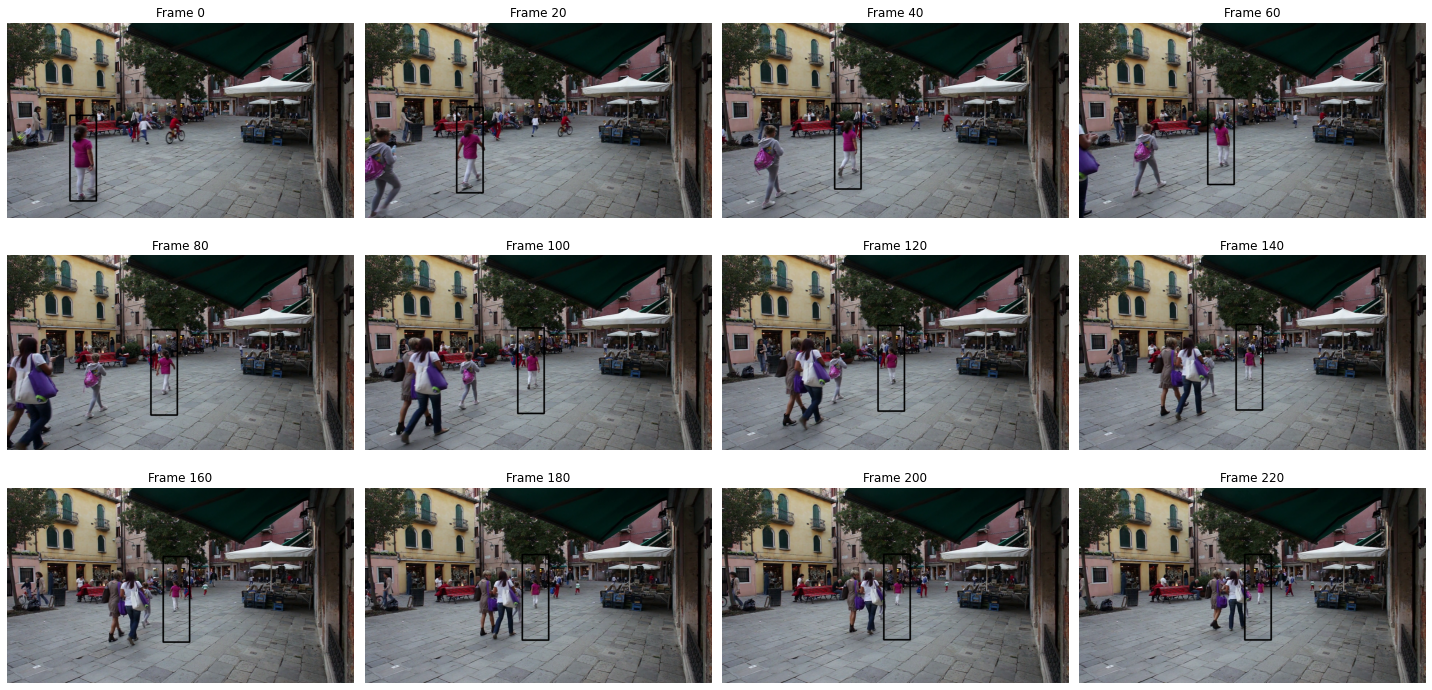

In [318]:
# show the tracking process
cols = len(key_frames)//3
fig, ax = plt.subplots(3, cols, figsize=(20, 10))
for i, frame in enumerate(key_frames):
    ax[i//cols][i%cols].imshow(frame[:,:,::-1])
    ax[i//cols][i%cols].axis('off')
    ax[i//cols][i%cols].set_title(f'Frame {i*20}')
plt.tight_layout()
plt.show()

This MOSSE tracker is doing quite well!

That's a wrap! Thanks for playing